In [ ]:
import os
import numpy as np
import tqdm
from datetime import datetime
import pickle
np.random.seed(420)

import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f"num cores: {n_cores}")
from multiprocessing import Pool
from functools import partial

from HMM import unsupervised_HMM, from_hmm
from HMM_helper import (
    parse_seqs,
    parse_text,
    update_syll_map,
    sample_sentence,
    visualize_sparsities,
    rhyme_dict_gen
)

# Preprocessing

In [ ]:
with open(os.path.join(os.getcwd(), 'data/shakespeare.txt'), 'r') as f:
    text = f.read()

with open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt'), 'r') as f:
    syll_map0 = {}
    for i, line in enumerate(f):
        line = line.strip().split()
        word = line[0] 
        # Add 10 to denote end of line syll_count
        sylls = np.array([int(s.replace('E', '1')) for s in line[1:]])
        assert(word not in syll_map0)
        syll_map0[word] = sylls

## Get maps and other relevant preprocessing data

In [3]:
by = 'line'
seqs = parse_text(text, by=by)
obs, obs_map = parse_seqs(seqs)
syll_map = update_syll_map(syll_map0, obs_map)
rhyme_d = rhyme_dict_gen(text, connected=False, with_words=False)

## Train a list of hmms, for each hidden state amount in latents

In [4]:
#pool = Pool(n_cores)
#
#map_func = partial(unsupervised_HMM, X=obs, N_iters=100, verbose=False)
#
#latents = [2, 4, 8, 16, 24, 32]
#hmms = list(tqdm.tqdm(pool.imap(map_func, latents), total=len(latents), desc='curr_hmm'))
#
#fName = f"by_{by}_hmm_list.pkl"
#with open(fName, 'wb') as f:
#    pickle.dump((hmms, latents), f)

In [5]:
fName = f"by_{by}_hmm_list.pkl"
with open(fName, 'rb') as f:
    hmms, latents = pickle.load(f)

for hmm, l in zip(hmms, latents):
    shmm = from_hmm(hmm, obs_map, syll_map, rhyme_d)
    with open(f"by_{by}_sonnet_list.txt", "a") as f:
        print(f"hidden_states = {l}", file=f)
        print("-" * 40, file=f)
        print(shmm.generate_sonnet(do_syll=True, do_rhyme=True), file=f)
        print("\n" * 2, file=f)

## Train single HMM

In [6]:
hmm = unsupervised_HMM(10, obs, 100, verbose=True)

fName = datetime.today().strftime('%y%m%d_%H%M') + f"_hmm{hmm.L}.pkl"
with open(fName, 'wb') as f:
    pickle.dump(hmm, f)

100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


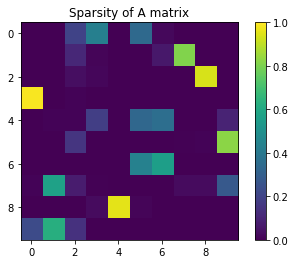

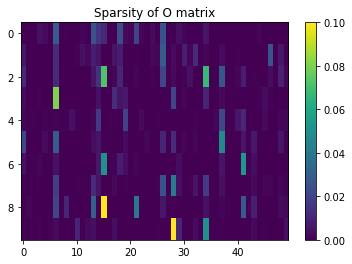

Sample Sentence:
A hope and your whilst then the fool of leave know no to that behind like been love with love's thinking of and of can...



Sample Sonet:
Still touch music me jewel may nor sing,
And now see better outward breath all east,
Love through verse truth hand seeming feeling wing,
Compounds worms me be their and 'i in west,
You usest extreme like then i will straight,
Of which love mother's to prognosticate,
That yet thy could thou a eye something bait,
Breathers where thou this are of leases date,
O say with thou when can disabled,
Be art acknowledge i oblivion near,
Your thanks bars each have grace his strumpeted,
Confound unrespected supposed her cheer,
Shall note beauty well of gluttoning love,
Shapes strive wish i self art do wilt were move,


In [7]:
by = 'sonnet'
with open(fName, 'rb') as f:
    hmm = pickle.load(f)

visualize_sparsities(hmm, O_max_cols=50)
print('Sample Sentence:\n====================')
print(sample_sentence(hmm, obs_map, n_words=25))
print('\n' * 2)

shmm = from_hmm(hmm, obs_map, syll_map, rhyme_d)
print('Sample Sonet:\n====================')
print(shmm.generate_sonnet(do_syll=True, do_rhyme=True))